In [1]:
import os
os.chdir("../")

In [2]:

import json
import matplotlib.pyplot as plt
import numpy as np
from robust_dst.scoring_utils import flatten_metrics_dict

/rds/user/ab2731/hpc-work/basic_env/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
version_1_folder = "metrics/seed_22_sdt_replication_v0_seq_full/original/dev/version_1"
version_3_folder = "fast_inference/seed_22_sdt_replication_v0_seq_full_with_separator_delimiter_token_version_3/SGD_SDT/version_3/dev"
version_4_folder = "fast_inference/seed_22_sdt_replication_v0_seq_full_with_separator_delimiter_ordered_version_4/SGD_SDT/version_4/dev"
version_2_folder = "fast_inference/seed_22_sdt_replication_v0_seq_full_version_2_new/SGD_SDT/version_2/dev"
v1 = "metrics/seed_22_sdt_replication_v1/original/dev/version_1"
v2 = "metrics/seed_22_sdt_replication_v2/original/dev/version_1"
v3 = "metrics/seed_22_sdt_replication_v3/original/dev/version_1"
v4 = "metrics/seed_22_sdt_replication_v4/original/dev/version_1"

In [4]:
class Plotter:
    JSON_KEYS = {"JGA": "#ALL_SERVICES/joint_goal_accuracy",
                "JGA_seen": "#SEEN_SERVICES/joint_goal_accuracy",
                "JGA_unseen": "#UNSEEN_SERVICES/joint_goal_accuracy",
                "JGA_cat": "#ALL_SERVICES/joint_cat_accuracy",
                "JGA_seen_cat": "#SEEN_SERVICES/joint_cat_accuracy",
                "JGA_unseen_cat": "#UNSEEN_SERVICES/joint_cat_accuracy",
                "JGA_non_cat": "#ALL_SERVICES/joint_noncat_accuracy",
                "JGA_seen_non_cat": "#SEEN_SERVICES/joint_noncat_accuracy",
                "JGA_unseen_non_cat": "#UNSEEN_SERVICES/joint_noncat_accuracy"}
    
    
    def plot_metrics(self, flattened_axs, label):
        for i, metric in enumerate(self.jgas):
            flattened_axs[i].plot(self.ckpts, self.jgas[metric], label=label)
            flattened_axs[i].set_title(metric)
            flattened_axs[i].legend()
            # set frequency of xticks to be every 10000 and represent them as 10k, 20k
            flattened_axs[i].set_xlabel("Steps")

class Metrics(Plotter):
    def __init__(self, metrics_folder):
        self.metrics_folder = metrics_folder
        self.jgas = {item: [] for item in self.JSON_KEYS.keys()}
        self.ckpts = []
        self.process()

    def process(self):
        files = os.listdir(self.metrics_folder)
        files.sort(key=lambda x: int(x.split("_")[1]))
        for file in files[:-1]:
            ckpt = int(file.split("_")[1])
            file = os.path.join(self.metrics_folder, file)
            with open(file, "r") as f:
                results = json.load(f)
            results = flatten_metrics_dict(results)
            self.ckpts.append(ckpt)
            for metric in self.JSON_KEYS:
                self.jgas[metric].append(results[self.JSON_KEYS[metric]])


class FastInference(Plotter):
    def __init__(self, main_folder, constraints):
        self.main_folder = main_folder
        self.constraints = constraints
        self.jgas = {item: [] for item in self.JSON_KEYS.keys()}
        self.ckpts = []
        self.process()
        
    def process(self):
        folders = os.listdir(self.main_folder)
        folders.sort(key=lambda x: int(x.split("-")[-1]))
        for folder in folders:
            ckpt = int(folder.split("-")[-1])
            path = os.path.join(self.main_folder, folder)
            path = os.path.join(path, self.constraints)
            path = os.path.join(path, "metrics.json")
            if os.path.exists(path):
                with open(path, "r") as f:
                    results = json.load(f)
                self.ckpts.append(ckpt)
                for metric in self.JSON_KEYS:
                    self.jgas[metric].append(results[self.JSON_KEYS[metric]])




In [5]:
v0_metrics = Metrics(version_1_folder)
v1_metrics = Metrics(v1)
v2_metrics = Metrics(v2)
v3_metrics = Metrics(v3)
v4_metrics = Metrics(v4)

In [6]:
v0_max = np.argmax(v0_metrics.jgas["JGA"])
v1_max = np.argmax(v1_metrics.jgas["JGA"])
v2_max = np.argmax(v2_metrics.jgas["JGA"])
v3_max = np.argmax(v3_metrics.jgas["JGA"])
v4_max = np.argmax(v4_metrics.jgas["JGA"])
print(v0_max, v0_metrics.ckpts[v0_max])
print(v1_max, v1_metrics.ckpts[v1_max])
print(v2_max, v2_metrics.ckpts[v2_max])
print(v3_max, v3_metrics.ckpts[v3_max])
print(v4_max, v4_metrics.ckpts[v4_max])

5 15000
6 17500
13 35000
8 22500
3 10000


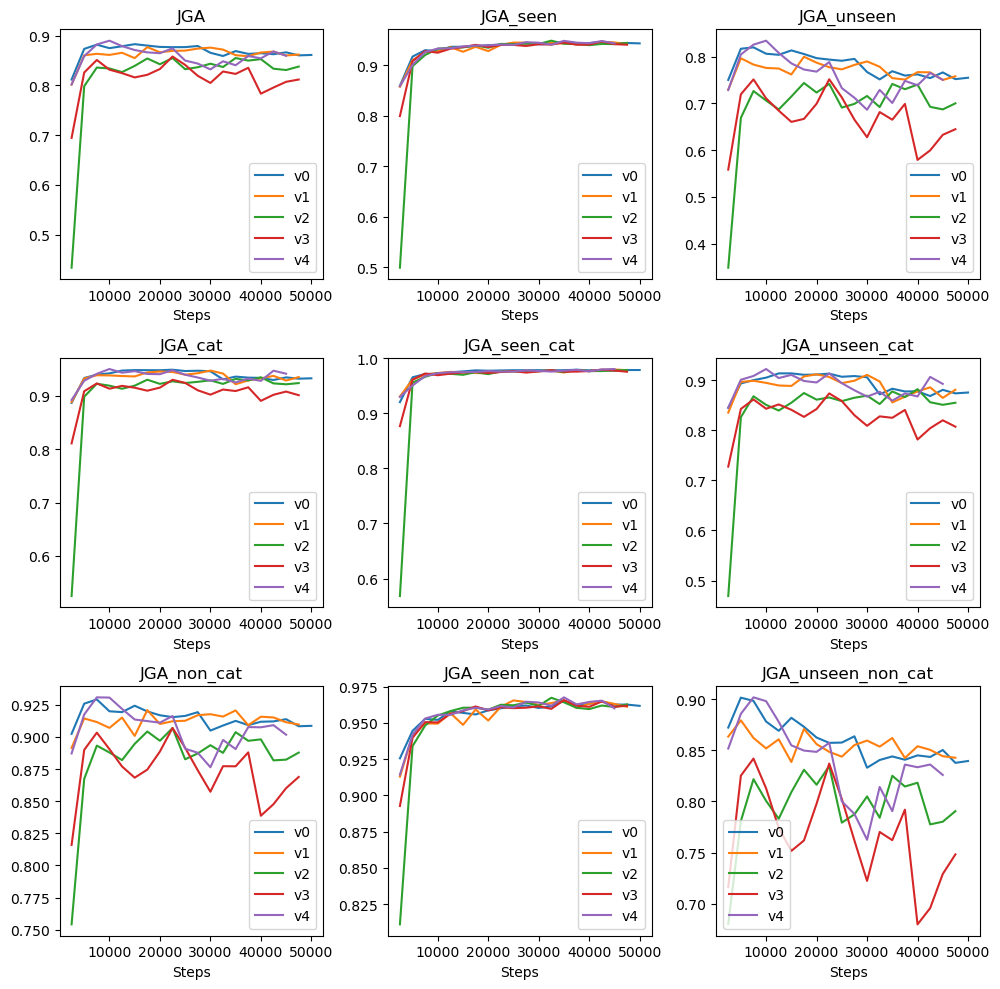

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
v0_metrics.plot_metrics(ax.flatten(), "v0")
v1_metrics.plot_metrics(ax.flatten(), "v1")
v2_metrics.plot_metrics(ax.flatten(), "v2")
v3_metrics.plot_metrics(ax.flatten(), "v3")
v4_metrics.plot_metrics(ax.flatten(), "v4")
fig.tight_layout()
plt.show()

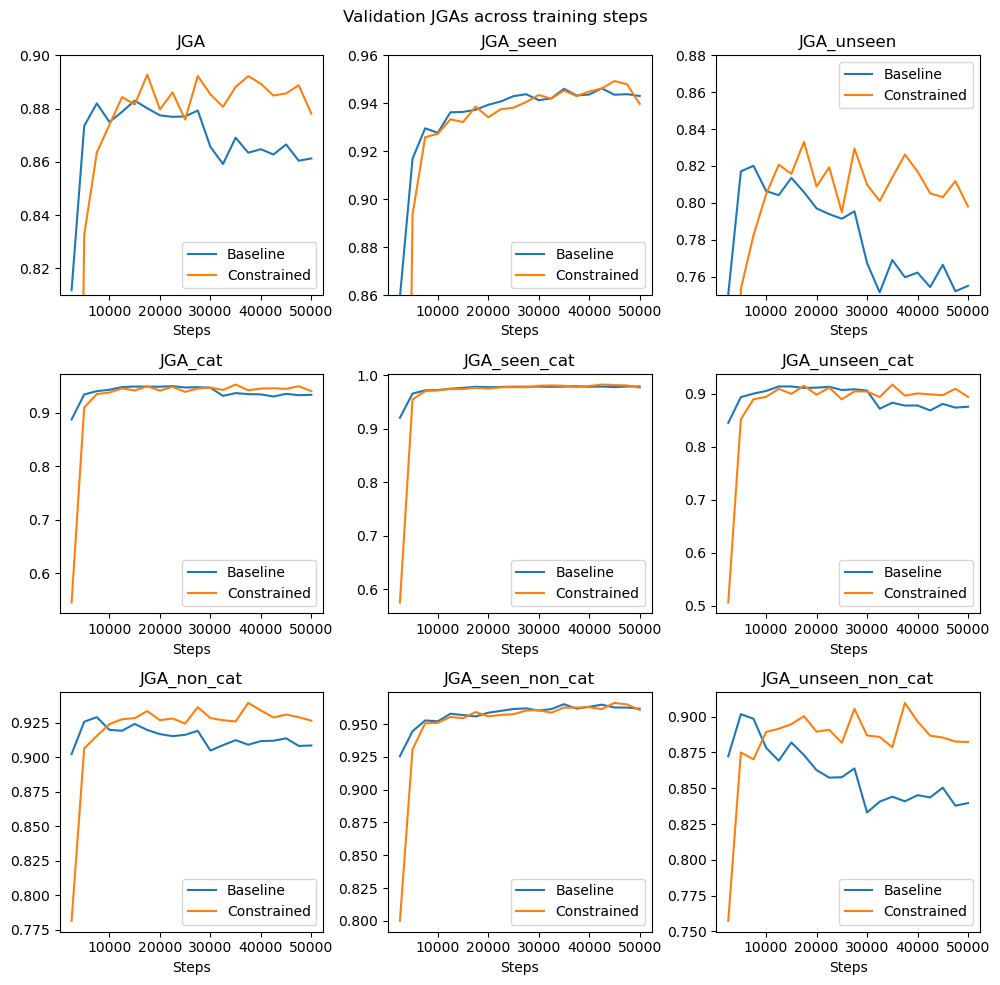

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
# How to transpose the ax matrix
#ax = ax.T
control_metrics.plot_metrics(ax.flatten(), "Baseline")
version_3_constrained.plot_metrics(ax.flatten(), "Constrained")
fig.suptitle("Validation JGAs across training steps")
ax[0,0].set_ylim(0.81, 0.9)
ax[0,1].set_ylim(0.86, 0.96)
ax[0,2].set_ylim(0.75, 0.88)
fig.tight_layout()


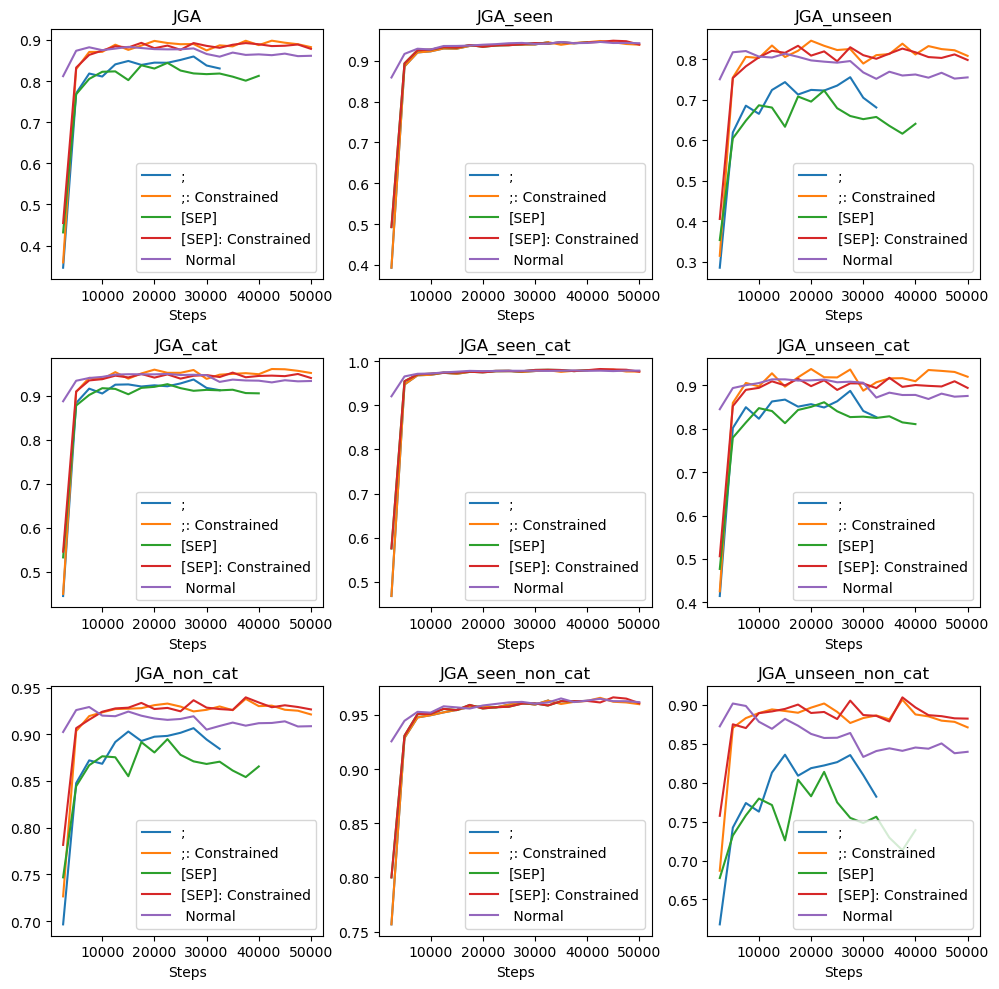

In [9]:

control_metrics = Metrics(version_1_folder)
version_2 = FastInference(version_2_folder, "no_constraints")
version_2_constrained = FastInference(version_2_folder, "constrained_new")
version_3 = FastInference(version_3_folder, "no_constraints")
version_3_constrained = FastInference(version_3_folder, "constrained_new")
version_4 = FastInference(version_4_folder, "no_constraints")
version_4_constrained = FastInference(version_4_folder, "constrained_new")
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
version_2.plot_metrics(ax.flatten(), ";")
version_2_constrained.plot_metrics(ax.flatten(), ";: Constrained")
version_3.plot_metrics(ax.flatten(), "[SEP]")
version_3_constrained.plot_metrics(ax.flatten(), "[SEP]: Constrained")
control_metrics.plot_metrics(ax.flatten(), " Normal ")
fig.tight_layout()
plt.show()
